In [60]:
# imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

# remove warnings for my own sanity
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.runtime_version")

In [ ]:
# paths (replace with wherever your data is located)
train_dir = "/Users/elipappas/.cache/kagglehub/datasets/datascientist97/forest-fire/versions/1/train"
test_dir = "/Users/elipappas/.cache/kagglehub/datasets/datascientist97/forest-fire/versions/1/test"

# training data - images and labels
train_images_dir = f"{train_dir}/images"
train_labels_dir = f"{train_dir}/labels"

# testing data - images and labels
test_images_dir = f"{test_dir}/images"
test_labels_dir = f"{test_dir}/labels"

# params
image_size = 128, 128
X = []
y = []

In [62]:
# function to load data - takes the image and label directories 
# as inputs with an added input for image size that defaults to (128, 128)
def load_yolo_binary_dataset(images_dir, labels_dir, image_size=(128, 128)):
    # initialize X and y to empty lists
    X, y = [], []
    
    # read in label file
    for label_file in os.listdir(labels_dir):
        # if the label_file is not a .txt file skip it
        if not label_file.endswith(".txt"):
            continue
        
        # read line in each file
        with open(os.path.join(labels_dir, label_file), "r") as f:
            lines = f.readlines()
        
        # first column in the file format is the class id
        class_ids = [int(line.split()[0]) for line in lines]
        label = 1 if any(cid == 1 for cid in class_ids) else 0
        
        # match image file with any extension
        base_name = os.path.splitext(label_file)[0]
        found_image = None

        # search for image file with matching base name
        for ext in [".jpg", ".jpeg", ".png"]:
            img_path = os.path.join(images_dir, base_name + ext)
            if os.path.exists(img_path):
                found_image = img_path
                break
        
        # if there is a matching image to the label open the image and resize it
        # before adding the image to the X and the label to the y
        if found_image:
            img = Image.open(found_image).convert("RGB")
            img = img.resize(image_size)
            X.append(np.array(img))
            y.append(label)
    
    # normalize the images and convert the labels and images to a numpy array
    X = np.array(X, dtype="float32") / 255.0
    y = np.array(y)

    # return the populated arrays
    return X, y


In [63]:
# load the training data
X_train, y_train = load_yolo_binary_dataset(train_images_dir, train_labels_dir)

# load the testing data
X_test, y_test = load_yolo_binary_dataset(test_images_dir, test_labels_dir)

In [64]:
# data transformation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

In [65]:
# define the sequential model
model = models.Sequential([
    # add convolutional layer with 32 filters, 
    # kernel size of (3,3), rectified linear unit activation, 
    # and the input shape (128,128,3) for the RGB images
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    # add max pooling layer which reduces the spatial dimensions
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    
    # flattens the 2d data into a 1d vector
    layers.Flatten(),
    # add a fully connected layer with 64 units
    layers.Dense(64, activation="relu"),
    # add output layer with 1 unit for binary classification
    layers.Dense(1, activation="sigmoid")
])

/Users/elipappas/Library/Python/3.13/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
# compile the model 
model.compile(
    # for optimization
    optimizer="adam",
    # for binary classification
    loss="binary_crossentropy",
    # what to track
    metrics=["accuracy"]
)

In [ ]:
# train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    verbose=1
)
print("training completed")

/Users/elipappas/Library/Python/3.13/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 97s 179ms/step - accuracy: 0.8630 - loss: 0.3417
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 97s 179ms/step - accuracy: 0.8630 - loss: 0.3417
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 105s 195ms/step - accuracy: 0.8942 - loss: 0.2579
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 105s 195ms/step - accuracy: 0.8942 - loss: 0.2579
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 107s 198ms/step - accuracy: 0.9128 - loss: 0.2184
Epoch 4/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 107s 198ms/step - accuracy: 0.9128 - loss: 0.2184
Epoch 4/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 111s 206ms/step - accuracy: 0.9227 - loss: 0.1968
539/539 ━━━━━━━━━━━━━━━━━━━━ 111s 206ms/step - accuracy: 0.9227 - loss: 0.1968
Epoch 5/20
Epoch 5/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.9288 - loss: 0.1819
539/539 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.9288 - loss: 0.1819
Epoch 6/20
Epoch 6/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 106s 197ms/step - accuracy: 0.9383 - loss: 0.1644
539/539 ━━━━

In [69]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
# print the results
print(f"Final Test Accuracy: {acc * 100:.2f}%")
print(f"Final Test Loss: {loss:.2f}")

Final Test Accuracy: 95.03%
Final Test Loss: 0.17


In [73]:
# save the model for future use
model.save("fire_classifier.keras")

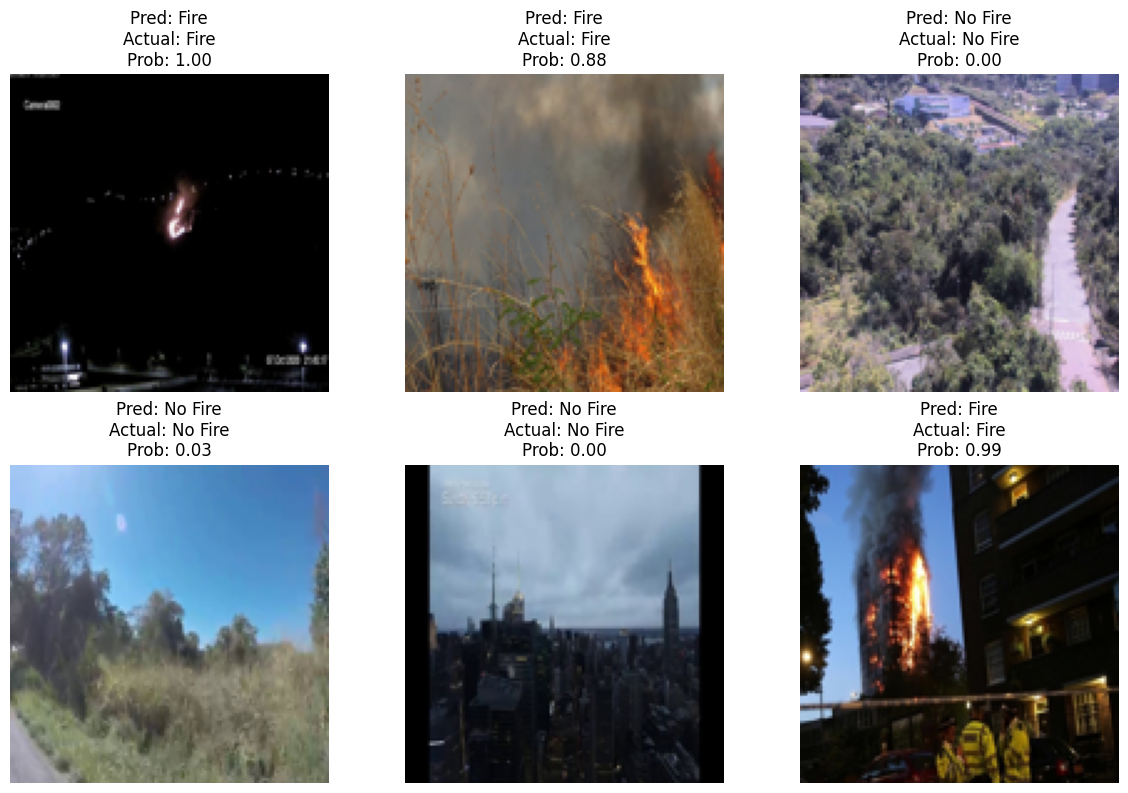

In [76]:
# show some example predictions from the test data using this model
num_examples = 6
indices = np.random.choice(len(X_test), num_examples, replace=False)

# plot the images and predictions
plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = y_test[idx]
    
    # model expects batch dimension, so expand dims
    pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
    pred_label = 1 if pred_prob >= 0.5 else 0
    
    # plot the image with prediction and true label
    plt.subplot(2, int(num_examples/2), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {'Fire' if pred_label == 1 else 'No Fire'}\n"
              f"Actual: {'Fire' if true_label == 1 else 'No Fire'}\n"
              f"Prob: {pred_prob:.2f}")

plt.tight_layout()
plt.show()